In [1]:
import math
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
torch.cuda.is_available()

False

In [2]:
def createCenterOutTargets(r, N_TARGETS):
    target = torch.empty(N_TARGETS, 2)
    for i in range(N_TARGETS):
        target[i,0] = r * np.cos(np.pi*2*i/N_TARGETS)
        target[i,1] = r * np.sin(np.pi*2*i/N_TARGETS)
    return target

In [3]:
# Hyperparameters
# Note: when MIN_DELAY and MAX_DELAY are too short compared to SEQLEN, 
# the network couldn't learn to hold. But if they are too long, it couldn't reach
SCREEN_SIZE = 20
INPUT_SIZE = 7
OUT_SIZE = 2
PADDING = 2
N_NEURONS = 256
MIN_DELAY = 30
MAX_DELAY = 60
MOVE_TARG_THRES = 2
HOLD_TARG_THRES = 1

PROP_GAIN = 0.2

SEQLEN = 500
N_TRAIN_EPOCHS = 21
N_TRAIN_STEPS = 2500
PRINT_EVERY=100

# Alphas and betas determine how much the teacher signal guides the learning of the neural network
ALPHAS = [0.8 ** k for k in range(N_TRAIN_EPOCHS)]
BETAS = [a / 2 for a in ALPHAS]

LEARNING_RATE = 1e-6

ACC_PENALTY = 5

# Define target locations for the pinball task and for the centerout task
TARGET_SEQUENCE = PADDING + np.random.rand(20, 2) * (SCREEN_SIZE - 2 * PADDING)
RADIUS = 5
N_TARGETS_CO = 8
TARGET_SEQUENCE_CO = SCREEN_SIZE/2 + createCenterOutTargets(RADIUS, N_TARGETS_CO)

In [4]:
if not os.path.isdir('./CenteroutModelResults-{}Epochs'.format(N_TRAIN_EPOCHS)):
    os.mkdir('./CenteroutModelResults-{}Epochs'.format(N_TRAIN_EPOCHS))

In [5]:
## Defines the RNN.
class MonkRNN(nn.Module):
    def __init__(self, inp_size, n_neurons, out_size):
        super(MonkRNN, self).__init__()

        self.inp_size = inp_size
        self.out_size = out_size
        self.n_neurons = n_neurons
        self.init_hidden_state = nn.Parameter(torch.zeros(1, n_neurons))

        # Inputs are:
        #  (go, hand_x, hand_y, curr_tgx, curr_tgy, next_tgx, next_tgy)
        self.inp_layer = nn.Sequential(nn.Linear(inp_size, n_neurons), nn.ReLU())
        
        self.teach_inp_layer = nn.Linear(2, n_neurons)
        self.teach_inp_layer.weight.data.normal_(0.0, 5 / np.sqrt(n_neurons))
        
        # Set teacher weights to constant.
        for p in self.teach_inp_layer.parameters():
            p.requires_grad = False
        
        # Recurrent layer parameters.
        self.rnn = nn.GRUCell(n_neurons, n_neurons)
        self.rnn.weight_hh.data.normal_(0, 2 / np.sqrt(n_neurons))

        # Output layer parameters
        self.out_layer = nn.Sequential(nn.Linear(n_neurons, n_neurons), nn.ReLU(), nn.Linear(n_neurons, out_size))
        self.out_layer[0].weight.data.normal_(0, 1.5 / np.sqrt(n_neurons))
        self.out_layer[2].weight.data.normal_(0, 1.5 / np.sqrt(n_neurons))
        
        # Strength of teacher input.
        self.alpha = 1.0

    def forward(self, inp, teach_inp, hidden=None):
        """
        Parameters
        ----------
        inp : torch.tensor
            Hand and target positions. Has shape (7,).
            (go, hand_x, hand_y, curr_tgx, curr_tgy, next_tgx, next_tgy)
        hidden : torch.tensor
            Initial firing rates. Has shape (n_neurons,)
        task_info : torch.tensor
            tensor holding (go, curr_tgx, curr_tgy, next_tgx, next_tgy)

        Returns
        -------
        acc : torch.tensor
            has shape (2,) corresponding to x and y acceleration.
        hiddens : torch.tensor
            has shape (n_neurons,) corresponding network activity.
        """

        if hidden is None:
            hidden = self.init_hidden_state

        # Update RNN one time step.
        fx = self.inp_layer(inp) + self.alpha * self.teach_inp_layer(teach_inp) # Feed input to the input layer.
        h_new = self.rnn(fx, hidden)

        # Collect RNN output (acceleration of hand).
        acc = self.out_layer(h_new)
        # print("hidden {}, Acc {}".format(h_new, acc))
        return acc, h_new

In [6]:
## The task class: tracks hand location, monitors is hand reaches the target, and controls the task to switch between delay period and movement period.
class PinballTask(nn.Module): 
    def __init__(self, hand, screen_size, min_delay, max_delay, move_targ_thres, hold_targ_thres, padding):
        super(PinballTask, self).__init__()
        self.screen_size = screen_size
        self.padding = padding
        self.move_targ_thres = move_targ_thres
        self.hold_targ_thres = hold_targ_thres

        self.delay_left = np.random.uniform(min_delay, max_delay)
        self.delay = self.delay_left
        self.min_delay = min_delay
        self.max_delay = max_delay

        self.go = torch.tensor([False])
        
        hx, hy = hand
        self.curr_tgx = hx
        self.curr_tgy = hy
#         self.next_tgx = padding + torch.rand(1) * (screen_size - 2 * padding)
#         self.next_tgy = padding + torch.rand(1) * (screen_size - 2 * padding)
        self.target_index = 0
        self.next_tgx = TARGET_SEQUENCE[0, 0]
        self.next_tgy = TARGET_SEQUENCE[0, 1]

    def forward(self, hand):
        """
        Parameters
        ----------
        hand : torch.tensor
            Hand positions and velocities
        """

        # Compute distances to targets
        hx, hy = hand
        dist_to_curr = torch.sqrt(
            (hx - self.curr_tgx) ** 2 + (hy - self.curr_tgy) ** 2)
        dist_to_next = torch.sqrt(
            (hx - self.next_tgx) ** 2 + (hy - self.next_tgy) ** 2)

        # Reach period
        if self.go:
            # assert False

            # Check for target acquired
            if dist_to_next < self.move_targ_thres:
                self.go = torch.tensor([False])
                #self.target_index += 1
                self.target_index = torch.randint(low = 0, high = len(TARGET_SEQUENCE), size = (1,1))
                self.curr_tgx = self.next_tgx
                self.curr_tgy = self.next_tgy
                self.next_tgx = TARGET_SEQUENCE[self.target_index, 0]
                self.next_tgy = TARGET_SEQUENCE[self.target_index, 1]
#                 self.next_tgx = self.padding + torch.rand(1) * (self.screen_size - 2 * self.padding)
#                 self.next_tgy = self.padding + torch.rand(1) * (self.screen_size - 2 * self.padding)
                self.delay_left = np.random.uniform(self.min_delay, self.max_delay)

        # Delay / Hold period
        else:
            # Check if hold is violated
            if dist_to_curr >= self.hold_targ_thres:
                self.delay_left = np.random.uniform(self.min_delay, self.max_delay)
            else:
                self.delay_left -=1
            
            # Check if delay is done.
            if self.delay_left <= 0:
                self.go = torch.tensor([True])
                
        return torch.tensor([
            self.go,
            hx,
            hy,
            self.curr_tgx,
            self.curr_tgy,
            self.next_tgx,
            self.next_tgy
        ])[None, :]


In [7]:
class CenterOutTask(nn.Module):

    def __init__(self, hand, screen_size, min_delay, max_delay, move_targ_thres, hold_targ_thres, padding):
        super(CenterOutTask, self).__init__()
        self.screen_size = screen_size
        self.padding = padding
        self.move_targ_thres = move_targ_thres
        self.hold_targ_thres = hold_targ_thres

        self.delay_left = np.random.uniform(min_delay, max_delay)
        self.delay = self.delay_left
        self.min_delay = min_delay
        self.max_delay = max_delay

        self.go = torch.tensor([False])
        
        hx, hy = hand
        self.curr_tgx = torch.tensor([SCREEN_SIZE / 2])
        self.curr_tgy = torch.tensor([SCREEN_SIZE / 2])
        self.target_index = 0
        self.next_tgx = TARGET_SEQUENCE_CO[0, 0]
        self.next_tgy = TARGET_SEQUENCE_CO[0, 1]

    def forward(self, hand):
        """
        Parameters
        ----------
        hand : torch.tensor
            Hand positions and velocities
        """

        # Compute distances to targets
        hx, hy = hand
        dist_to_curr = torch.sqrt(
            (hx - self.curr_tgx) ** 2 + (hy - self.curr_tgy) ** 2)
        dist_to_next = torch.sqrt(
            (hx - self.next_tgx) ** 2 + (hy - self.next_tgy) ** 2)

        # Reach period
        if self.go:
            # assert False

            # Check for target acquired
            if dist_to_next < self.move_targ_thres:
                self.go = torch.tensor([False])
                #self.target_index += 1
                self.target_index = torch.randint(low = 0, high = len(TARGET_SEQUENCE_CO), size = (1,1))
                hx = torch.tensor([SCREEN_SIZE / 2])
                hy = torch.tensor([SCREEN_SIZE / 2])
                self.next_tgx = TARGET_SEQUENCE_CO[self.target_index, 0]
                self.next_tgy = TARGET_SEQUENCE_CO[self.target_index, 1]
                self.delay_left = np.random.uniform(self.min_delay, self.max_delay)

        # Delay / Hold period
        else:
            # Check if hold is violated
            if dist_to_curr >= self.hold_targ_thres:
                self.delay_left = np.random.uniform(self.min_delay, self.max_delay)
            else:
                self.delay_left -=1
            
            # Check if delay is done.
            if self.delay_left <= 0:
                self.go = torch.tensor([True])
                
        return torch.tensor([
            self.go,
            hx,
            hy,
            self.curr_tgx,
            self.curr_tgy,
            self.next_tgx,
            self.next_tgy
        ])[None, :]


In [8]:
## Compute losses based on hand location and the smoothness (penalize abrupt hand acceleration) of movement
class PinballCriterion(nn.Module):

    def __init__(self, acc_penalty):
        super(PinballCriterion, self).__init__()
        self.acc_penalty = acc_penalty

    def get_active_target(self, inp_hist):
        """Compute the active target at each timestep."""
        go = inp_hist[:, 0]
        curr_targ = inp_hist[:, 3:5]
        next_targ = inp_hist[:, 5:7]
        return curr_targ * (1 - go[:, None]) + next_targ * go[:, None]
        
    def target_loss(self, inp_hist):
        """Computes loss between hand and active target."""
        active_targ = self.get_active_target(inp_hist)
        return torch.mean((inp_hist[:, 1:3] - active_targ) ** 2)

    def acc_loss(self, acc_hist):
        """Computes penalty on the acceleration."""
        return self.acc_penalty * torch.mean(acc_hist ** 2)
    
    def forward(self, inp_hist, acc_hist):
        """
        Parameters
        ----------
        inp_hist : torch.tensor
            has shape (n_timesteps, 4) corresponding to (hx, hy, vx, vy) at each timepoint.
        acc_hist : torch.tensor
            has shape (n_timesteps, 2) corresponding to accelations
        """
        target_loss = self.target_loss(inp_hist)
        acc_loss = self.acc_loss(acc_hist)
        return target_loss + acc_loss

In [9]:
## Compute the teaching signal based on the difference between current hand acceleration and target hand acc (this is the vector pointing from current hand location to the target location).
class TeacherHandDynamics(nn.Module):
    def __init__(self, screen_size, friction=5.0, teacher_scale=1.0):
        super(TeacherHandDynamics, self).__init__()
        self.screen_size = screen_size
        self.friction = friction
        self.teacher_scale = teacher_scale

    def initialize(self, hx, hy):
        self.hx = torch.tensor([hx])
        self.hy = torch.tensor([hy])
        self.vx = torch.zeros(1)
        self.vy = torch.zeros(1)
        self.int_errx = 0.0
        self.int_erry = 0.0

    def forward(self, acc, targ_loc):
        """
        Parameters
        ----------
        acc : torch.tensor
            has shape (2,) correspond to (ax, ay)
        targ_loc : torch.tensor
            location of the current target
        
        Returns
        -------
        hand : torch.tensor
            has shape (2,) corresponding to (hx, hy).
        """
        acc = acc.squeeze()
        
        hx = self.hx.item()
        hy = self.hy.item()
        tgx = targ_loc[0].item()
        tgy = targ_loc[1].item()

        # Teacher direction
        errx = (tgx - hx)
        erry = (tgy - hy)
        self.int_errx += 0.9 * errx
        self.int_erry += 0.9 * erry
        
        teach_x = 0.01 * self.int_errx + PROP_GAIN * errx
        teach_y = 0.01 * self.int_erry + PROP_GAIN * erry

        # Add teacher contribution
        ax = teach_x * self.teacher_scale + acc[0] * (1 - self.teacher_scale)
        ay = teach_y * self.teacher_scale + acc[1] * (1 - self.teacher_scale)

        self.vx = self.vx / self.friction + ax
        self.vy = self.vy / self.friction + ay
        self.hx = torch.clamp(self.hx + self.vx, .1, self.screen_size - .1)
        self.hy = torch.clamp(self.hy + self.vy, .1, self.screen_size - .1)
        
        teacher_loss = (teach_x - acc[0]) ** 2 + (teach_y - acc[1]) ** 2

        return (
            torch.cat((self.hx, self.hy)),
            teacher_loss,
            torch.tensor([teach_x, teach_y]),
        )

In [10]:
# Define transformations.
rnn = MonkRNN(INPUT_SIZE, N_NEURONS, OUT_SIZE)
hand_dynamics = TeacherHandDynamics(SCREEN_SIZE, teacher_scale=0.1)
crit = PinballCriterion(ACC_PENALTY)
# optimizer = torch.optim.Adam(rnn.parameters(), lr = LEARNING_RATE)
optimizer = torch.optim.SGD(rnn.parameters(), lr=LEARNING_RATE)

In [11]:
# This section is written for continuing training from a trained RNN
# rnn = torch.load('./CenteroutModelResults-20Epochs/MonkRNN_TrainedModel_CenteroutEpoch14.pt')
# hand_dynamics = torch.load('./CenteroutModelResults-20Epochs/MonkRNN_TrainingHandDynamics_CenteroutEpoch14.pt')

# ALPHAS = [0.8 ** k for k in range(20)]
# BETAS = [a / 2 for a in ALPHAS]

In [12]:
## TRAIN NETWORK ##

losses = []

for epoch in range(N_TRAIN_EPOCHS):

    hand_dynamics.teacher_scale = BETAS[epoch]
    rnn.alpha = ALPHAS[epoch]
    
    for k in range(N_TRAIN_STEPS):

        # randomize hand position (no velocity).
        hand_dynamics.initialize(SCREEN_SIZE / 2, SCREEN_SIZE / 2)
        hand, _, teach_signal = hand_dynamics(
            torch.zeros(2),
            torch.tensor([TARGET_SEQUENCE_CO[0,0], TARGET_SEQUENCE_CO[0,1]]) # initial "target"
        )

        # Initialize task.
        hidden = None
        task = CenterOutTask(hand, SCREEN_SIZE, MIN_DELAY, MAX_DELAY, MOVE_TARG_THRES, HOLD_TARG_THRES, PADDING)
        inp = task(hand)

        # Allocate storage
        inp_hist = torch.empty(SEQLEN, INPUT_SIZE)
        acc_hist = torch.empty(SEQLEN, OUT_SIZE)
        hidden_hist = torch.empty(SEQLEN, N_NEURONS)
        
        # Zero out the gradient
        optimizer.zero_grad()

        loss = torch.tensor([0.0])

        # Now simulate the trial
        for t in range(SEQLEN):
            # Update the RNN activity
            acc, hidden = rnn(inp, teach_signal, hidden)

            if inp[0, 0] > 0.1:
                active_target = inp[0, 5:7] # go cue on
            else:
                active_target = inp[0, 3:5] # go cue off

            # Update hand position one time step
            hand, teach_loss, teach_signal = hand_dynamics(acc, active_target)
            loss += teach_loss
            
            # Store outputs
            inp_hist[t] = inp
            acc_hist[t] = acc
            hidden_hist[t] = hidden
            
            # Update target locations.
            inp = task(hand)
            
        # Compute loss, and do backprop.
    #     loss = crit(inp_hist, acc_hist)
        loss.backward()
        losses.append(loss.item())

        # Update the weights
        optimizer.step()
        
        # Save the rnn model
        torch.save(rnn, './CenteroutModelResults-{}Epochs/MonkRNN_TrainedModel_CenteroutEpoch{}.pt'.format(N_TRAIN_EPOCHS, epoch))
        torch.save(hand_dynamics, './CenteroutModelResults-{}Epochs/MonkRNN_TrainingHandDynamics_CenteroutEpoch{}.pt'.format(N_TRAIN_EPOCHS, epoch))
        # Save neuron firing rates
        torch.save(hidden_hist, './CenteroutModelResults-{}Epochs/neuronFiringRatesTraining_MonkRNN_CenteroutEpoch{}.pt'.format(N_TRAIN_EPOCHS, epoch))
        # Save target locations, hand positions and accelerations of each step in the last epoch
        torch.save(inp_hist, './CenteroutModelResults-{}Epochs/handPositionsTraining_MonkRNN_CenteroutEpoch{}.pt'.format(N_TRAIN_EPOCHS, epoch))
        torch.save(acc_hist, './CenteroutModelResults-{}Epochs/handAccTraining_MonkRNN_CenteroutEpoch{}.pt'.format(N_TRAIN_EPOCHS, epoch))
        if (k % PRINT_EVERY) == 0:
            print("Epoch {}, Step {}, Loss {}".format(epoch, k, losses[-1]))
    #         print("inputs {}, acc {}".format(inp_hist, acc_hist))
    #         plt.plot(np.array(inp_hist[:,1]),np.array(inp_hist[:,2]), color = colors[plot_ind], label=k) 
    #         plt.plot(inp_hist[1,5],inp_hist[1,6],'.',markersize=10, color = colors[plot_ind])
    #         plot_ind +=1

# Save losses of each step in all training epochs
torch.save(losses, './CenteroutModelResults-{}Epochs/lossesTraining_MonkRNN_CenteroutEpoch{}.pt'.format(N_TRAIN_EPOCHS, epoch))
torch.save(TARGET_SEQUENCE, './CenteroutModelResults-{}Epochs/targetSequence_100Targets.pt'.format(N_TRAIN_EPOCHS))

C:\Users\markp\anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type MonkRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\markp\anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type TeacherHandDynamics. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 0, Step 0, Loss 6004.97216796875
Epoch 0, Step 100, Loss 40.71324920654297
Epoch 0, Step 200, Loss 42.238319396972656
Epoch 0, Step 300, Loss 38.4250602722168
Epoch 0, Step 400, Loss 31.741153717041016
Epoch 0, Step 500, Loss 30.938249588012695
Epoch 0, Step 600, Loss 34.407203674316406
Epoch 0, Step 700, Loss 34.160621643066406
Epoch 0, Step 800, Loss 28.65470314025879
Epoch 0, Step 900, Loss 27.742162704467773
Epoch 0, Step 1000, Loss 26.49353790283203
Epoch 0, Step 1100, Loss 27.41535758972168
Epoch 0, Step 1200, Loss 27.486766815185547
Epoch 0, Step 1300, Loss 28.19778060913086
Epoch 0, Step 1400, Loss 21.324905395507812
Epoch 0, Step 1500, Loss 29.33571434020996
Epoch 0, Step 1600, Loss 26.964658737182617
Epoch 0, Step 1700, Loss 20.267892837524414
Epoch 0, Step 1800, Loss 21.158477783203125
Epoch 0, Step 1900, Loss 19.888172149658203
Epoch 0, Step 2000, Loss 24.23923683166504
Epoch 0, Step 2100, Loss 23.237125396728516
Epoch 0, Step 2200, Loss 21.19231605529785
Epoch 0, Ste

KeyboardInterrupt: 

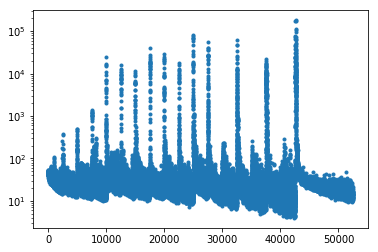

In [ ]:
plt.plot(losses[50:],'.') 
plt.yscale('log')
plt.show()

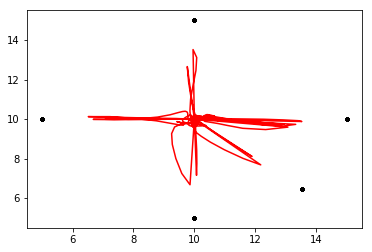

In [ ]:
plt.plot(np.array(inp_hist[:,1]),np.array(inp_hist[:,2]), 'r', label=k) 
plt.plot(inp_hist[:,5].detach().numpy(),inp_hist[:,6].detach().numpy(),'k.')

plt.show()

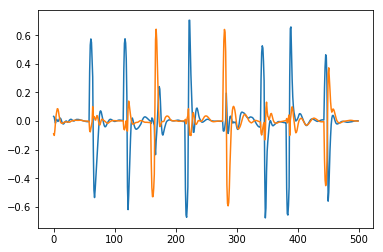

In [ ]:
plt.plot(acc_hist.detach().numpy())

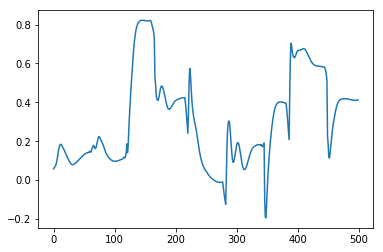

In [ ]:
plt.plot(hidden_hist[:,201].detach().numpy())

In [ ]:
epoch = 2
rnn = torch.load('./CenteroutModelResults-20Epochs/MonkRNN_TrainedModel_CenteroutEpoch{}.pt'.format(epoch))
hand_dynamics = torch.load('./CenteroutModelResults-20Epochs/MonkRNN_TrainingHandDynamics_CenteroutEpoch{}.pt'.format(epoch))

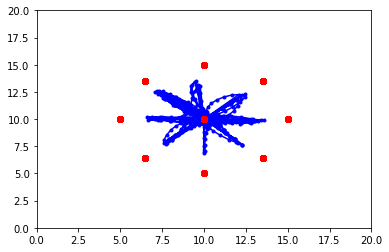

In [ ]:
## TEST NETWORK ON NEW INPUTS THE SAME CENTEROUT TASK##

N_TEST = 50
TEST_SEQLEN = 2000
hand_dynamics.teacher_scale = 0
rnn.alpha = 0.005
losses_test = []
crit = PinballCriterion(ACC_PENALTY)

for n in range(N_TEST):
    
    # randomize hand position (no velocity).
    hand_dynamics.initialize(SCREEN_SIZE / 2, SCREEN_SIZE / 2)
    hand, _, teach_signal = hand_dynamics(
        torch.zeros(2),
        torch.tensor([SCREEN_SIZE / 2, SCREEN_SIZE / 2]) # initial "target"
    )

    # Initialize task.
    hidden = None
    task = CenterOutTask(hand, SCREEN_SIZE, MIN_DELAY, MAX_DELAY, MOVE_TARG_THRES, HOLD_TARG_THRES, PADDING)
    inp = task(hand)

    # Allocate storage
    inp_hist_test = torch.empty(TEST_SEQLEN, 7)
    acc_hist_test = torch.empty(TEST_SEQLEN, 2)
    hidden_hist_test = torch.empty(TEST_SEQLEN, N_NEURONS)
    teach_signal_hist = torch.empty(TEST_SEQLEN, 2)
    loss = torch.tensor([0.0])

    # Now simulate the trial
    for t in range(TEST_SEQLEN):

        # Update the RNN activity
        acc, hidden = rnn(inp, teach_signal, hidden)

        if inp[0, 0] > 0.1:
            active_target = inp[0, 5:7] # go cue on
        else:
            active_target = inp[0, 3:5] # go cue off

        # Update hand position one time step
        hand, teach_loss, teach_signal = hand_dynamics(acc, active_target)
        loss += teach_loss
        # Store outputs
        inp_hist_test[t] = inp
        acc_hist_test[t] = acc
        hidden_hist_test[t] = hidden
        teach_signal_hist[t] = teach_signal

        # Update target locations.
        inp = task(hand)
    losses_test.append(loss.item())

hx = inp_hist_test[:, 1].detach().numpy()
hy = inp_hist_test[:, 2].detach().numpy()

active_targ = crit.get_active_target(inp_hist_test)
tx = active_targ[:, 0].detach().numpy()
ty = active_targ[:, 1].detach().numpy()

plt.figure()
plt.plot(hx, hy, '.-b')
plt.plot(tx, ty, 'or')
plt.xlim([0, SCREEN_SIZE])
plt.ylim([0, SCREEN_SIZE])

# Save neuron firing rates
torch.save(hidden_hist_test, './CenteroutModelResults-{}Epochs/neuronFiringRatesTest_MonkRNN_Centerout_Alpha0005_Epoch{}.pt'.format(N_TRAIN_EPOCHS, epoch))
torch.save(inp_hist_test, './CenteroutModelResults-{}Epochs/handPositionsTest_MonkRNN_Centerout_Alpha0005_Epoch{}.pt'.format(N_TRAIN_EPOCHS, epoch))
torch.save(acc_hist_test, './CenteroutModelResults-{}Epochs/handAccTest_MonkRNN_Centerout_Alpha0005_Epoch{}.pt'.format(N_TRAIN_EPOCHS, epoch))
torch.save(teach_signal_hist, './CenteroutModelResults-{}Epochs/teach_signal_Test_MonkRNN_Centerout_Alpha0005_Epoch{}.pt'.format(N_TRAIN_EPOCHS, epoch))
torch.save(losses_test, './CenteroutModelResults-{}Epochs/lossesTest_MonkRNN_Centerout_Alpha0005_Epoch{}.pt'.format(N_TRAIN_EPOCHS, epoch))

In [ ]:
np.mean(losses_test)

203.41021804809571

In [ ]:
epoch = 12
rnn = torch.load('./CenteroutModelResults-20Epochs/MonkRNN_TrainedModel_CenteroutEpoch{}.pt'.format(epoch))
hand_dynamics = torch.load('./CenteroutModelResults-20Epochs/MonkRNN_TrainingHandDynamics_CenteroutEpoch{}.pt'.format(epoch))

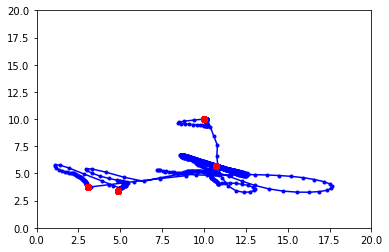

In [ ]:
## TEST NETWORK ON NEW INPUTS FOR A PINBALL TASK, WITH TARGET_SEQUENCE AS THE RANDOM TARGET LOCATIONS##

N_TEST = 50
TEST_SEQLEN = 2000
hand_dynamics.teacher_scale = 0
rnn.alpha = 0.08
losses_test = []
crit = PinballCriterion(ACC_PENALTY)

for n in range(N_TEST):
    
    # randomize hand position (no velocity).
    hand_dynamics.initialize(SCREEN_SIZE / 2, SCREEN_SIZE / 2)
    hand, _, teach_signal = hand_dynamics(
        torch.zeros(2),
        torch.tensor([SCREEN_SIZE / 2, SCREEN_SIZE / 2]) # initial "target"
    )

    # Initialize task.
    hidden = None
    task = PinballTask(hand, SCREEN_SIZE, MIN_DELAY, MAX_DELAY, MOVE_TARG_THRES, HOLD_TARG_THRES, PADDING)
    inp = task(hand)

    # Allocate storage
    inp_hist_test = torch.empty(TEST_SEQLEN, 7)
    acc_hist_test = torch.empty(TEST_SEQLEN, 2)
    hidden_hist_test = torch.empty(TEST_SEQLEN, N_NEURONS)
    teach_signal_hist = torch.empty(TEST_SEQLEN, 2)
    loss = torch.tensor([0.0])
    # Now simulate the trial
    for t in range(TEST_SEQLEN):

        # Update the RNN activity
        acc, hidden = rnn(inp, teach_signal, hidden)

        if inp[0, 0] > 0.1:
            active_target = inp[0, 5:7] # go cue on
        else:
            active_target = inp[0, 3:5] # go cue off

        # Update hand position one time step
        hand, teach_loss, teach_signal = hand_dynamics(acc, active_target)
        loss += teach_loss

        # Store outputs
        inp_hist_test[t] = inp
        acc_hist_test[t] = acc
        hidden_hist_test[t] = hidden
        teach_signal_hist[t] = teach_signal

        # Update target locations.
        inp = task(hand)
    losses_test.append(loss.item())

hx = inp_hist_test[:, 1].detach().numpy()
hy = inp_hist_test[:, 2].detach().numpy()

active_targ = crit.get_active_target(inp_hist_test)
tx = active_targ[:, 0].detach().numpy()
ty = active_targ[:, 1].detach().numpy()

plt.figure()
plt.plot(hx, hy, '.-b')
plt.plot(tx, ty, 'or')
plt.xlim([0, SCREEN_SIZE])
plt.ylim([0, SCREEN_SIZE])

# Save neuron firing rates
# torch.save(hidden_hist_test, './CenteroutModelResults-{}Epochs/neuronFiringRatesTest_MonkRNN_Pinball_Alpha010_Epoch{}.pt'.format(N_TRAIN_EPOCHS, epoch))
# torch.save(inp_hist_test, './CenteroutModelResults-{}Epochs/handPositionsTest_MonkRNN_Pinball_Alpha010_Epoch{}.pt'.format(N_TRAIN_EPOCHS, epoch))
# torch.save(acc_hist_test, './CenteroutModelResults-{}Epochs/handAccTest_MonkRNN_Pinball_Alpha010_Epoch{}.pt'.format(N_TRAIN_EPOCHS, epoch))
# torch.save(teach_signal_hist, './CenteroutModelResults-{}Epochs/teach_signal_Test_MonkRNN_Pinball_Alpha010_Epoch{}.pt'.format(N_TRAIN_EPOCHS, epoch))
torch.save(losses_test, './CenteroutModelResults-{}Epochs/lossesTest_MonkRNN_Pinball_Alpha008_Epoch{}.pt'.format(N_TRAIN_EPOCHS, epoch))

In [ ]:
np.mean(losses_test)

12240.601462402345

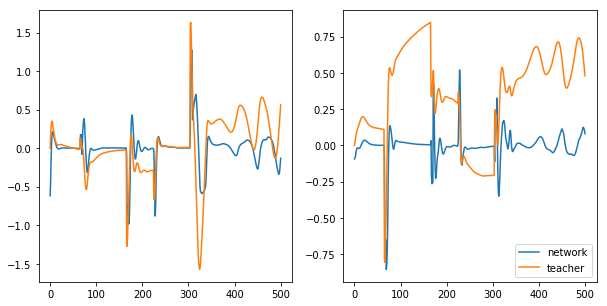

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for k, ax in enumerate(axes):
    ax.plot(acc_hist_test.detach().numpy()[0:501, k], label='network')
    ax.plot(teach_signal_hist.detach().numpy()[0:501, k], label='teacher')
axes[-1].legend()

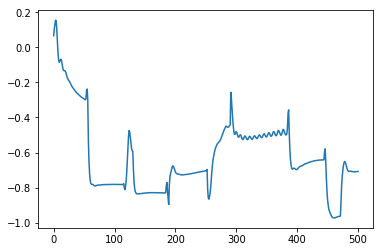

In [ ]:
plt.plot(hidden_hist_test[0:501,2].detach().numpy())